In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from src.helper_functions import train_step, test_step, accuracy_fn, run_model
from src.few_shot_learning import set_seed, calculate_accuracy, load_cinic10, plot_confusion_matrix
from src.plots_functions import multiple_runs_with_uncertainty_band
set_seed(213)

In [2]:
class FewShotResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(FewShotResNet, self).__init__()
        self.backbone = models.resnet18(weights="IMAGENET1K_V1")  # Load pretrained model
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)  # Replace last layer
    
    def forward(self, x):
        return self.backbone(x)

In [3]:
torch.hub.set_dir("../../models")

In [4]:
def train_few_shot(model, train_dataloader, test_dataloader, epochs=10, lr=0.001, optimizer="adam", unfreezed_layers = 2, silent=False):
    for param in model.backbone.parameters():
        param.requires_grad = False  # Freeze all layers
    
    if unfreezed_layers > 3:
        for param in model.backbone.layer1.parameters():
            param.requires_grad = True
    if unfreezed_layers > 2:
        for param in model.backbone.layer2.parameters():
            param.requires_grad = True
    if unfreezed_layers > 1:
        for param in model.backbone.layer3.parameters():
            param.requires_grad = True
    if unfreezed_layers > 0:
        for param in model.backbone.layer4.parameters():
            param.requires_grad = True
            
    for param in model.backbone.fc.parameters():
        param.requires_grad = True
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    if optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    
    return run_model(train_dataloader, test_dataloader, model, criterion, optimizer, device, epochs, silent=silent)


In [5]:
data_dir = "../../data"
train_dataloader = load_cinic10(data_dir, few_shot_per_class=100)
test_dataloader = load_cinic10(data_dir, few_shot_per_class=100, split="test")

In [7]:
metrics_list = []
for _ in range(5):
    model = FewShotResNet(num_classes=10)
    metrics, time = train_few_shot(model, train_dataloader, test_dataloader, epochs=30, lr=0.001)
    metrics_list.append(metrics)

Train loss: 2.35195 | Train accuracy: 22.02%
Test loss: 2.15273 | Test accuracy: 30.06%

Train loss: 1.81735 | Train accuracy: 34.72%
Test loss: 1.67338 | Test accuracy: 35.91%

Train loss: 1.48837 | Train accuracy: 40.77%
Test loss: 1.87975 | Test accuracy: 35.12%

Train loss: 1.27212 | Train accuracy: 53.67%
Test loss: 1.78314 | Test accuracy: 37.70%

Train loss: 1.09588 | Train accuracy: 60.81%
Test loss: 2.16192 | Test accuracy: 37.30%

Train loss: 0.78638 | Train accuracy: 73.61%
Test loss: 2.25205 | Test accuracy: 35.81%

Train loss: 0.65558 | Train accuracy: 76.98%
Test loss: 2.14097 | Test accuracy: 37.70%

Train loss: 0.59093 | Train accuracy: 81.65%
Test loss: 2.12529 | Test accuracy: 39.58%

Train loss: 0.44708 | Train accuracy: 84.92%
Test loss: 2.23022 | Test accuracy: 40.58%

Train loss: 0.45152 | Train accuracy: 87.00%
Test loss: 2.50238 | Test accuracy: 43.25%

Train loss: 0.34775 | Train accuracy: 88.39%
Test loss: 2.40518 | Test accuracy: 44.64%

Train loss: 0.19308 |

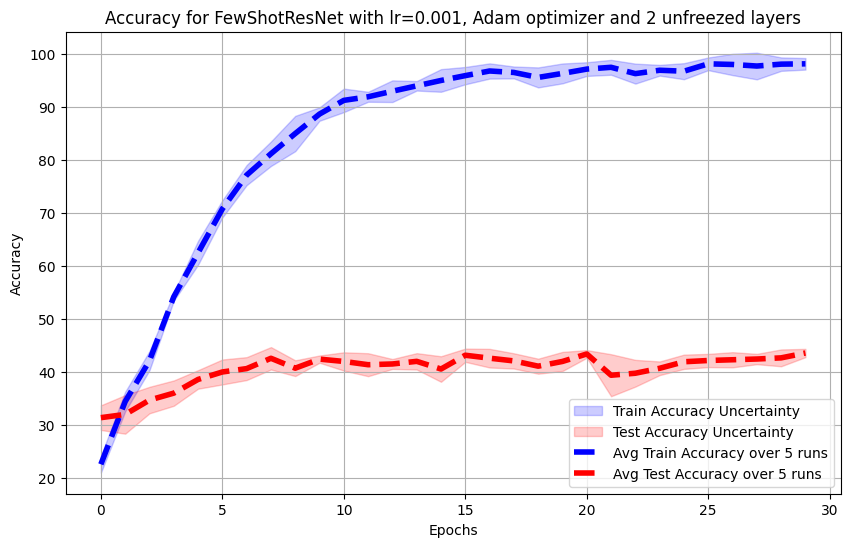

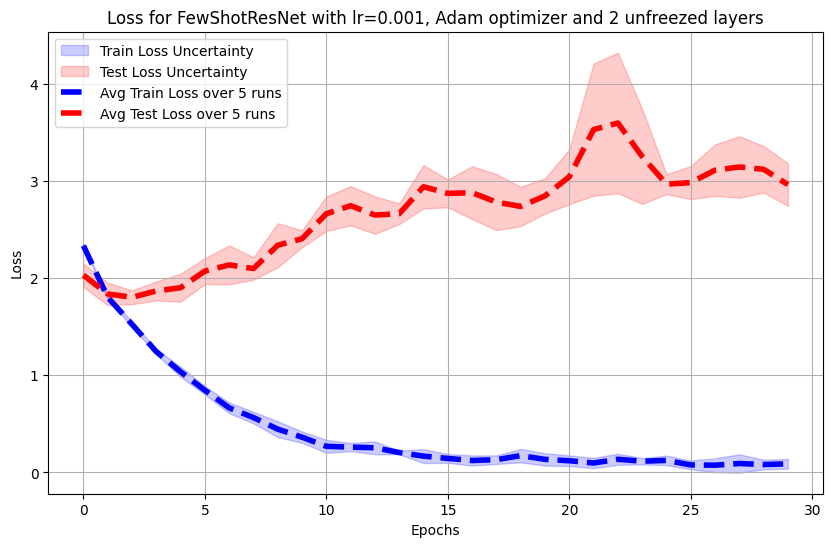

In [9]:
experiment_name = "FewShotResNet with lr=0.001, Adam optimizer and 2 unfreezed layers"
multiple_runs_with_uncertainty_band(metrics_list, f"Accuracy for {experiment_name}", f"Loss for {experiment_name}")

In [10]:
metrics_list = []
for _ in range(5):
    model = FewShotResNet(num_classes=10)
    metrics, time = train_few_shot(model, train_dataloader, test_dataloader, epochs=20, lr=0.01)
    metrics_list.append(metrics)

Train loss: 3.62648 | Train accuracy: 13.99%
Test loss: 3.85547 | Test accuracy: 18.85%

Train loss: 2.05245 | Train accuracy: 24.70%
Test loss: 2.03355 | Test accuracy: 24.70%

Train loss: 1.74556 | Train accuracy: 34.42%
Test loss: 1.70784 | Test accuracy: 35.91%

Train loss: 1.50191 | Train accuracy: 41.77%
Test loss: 1.89527 | Test accuracy: 36.71%

Train loss: 1.29700 | Train accuracy: 49.80%
Test loss: 1.75159 | Test accuracy: 36.41%

Train loss: 1.15894 | Train accuracy: 54.46%
Test loss: 1.74776 | Test accuracy: 40.18%

Train loss: 1.02275 | Train accuracy: 58.53%
Test loss: 1.79560 | Test accuracy: 39.78%

Train loss: 0.86517 | Train accuracy: 65.38%
Test loss: 2.12328 | Test accuracy: 39.29%

Train loss: 0.74754 | Train accuracy: 71.33%
Test loss: 2.25397 | Test accuracy: 36.01%

Train loss: 0.64477 | Train accuracy: 75.50%
Test loss: 2.56704 | Test accuracy: 31.35%

Train loss: 0.58707 | Train accuracy: 79.96%
Test loss: 2.37446 | Test accuracy: 39.38%

Train loss: 0.46979 |

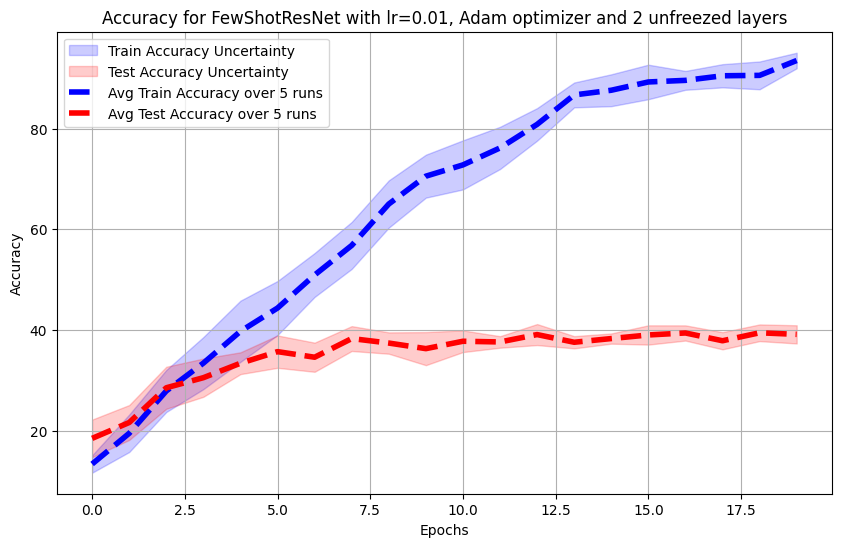

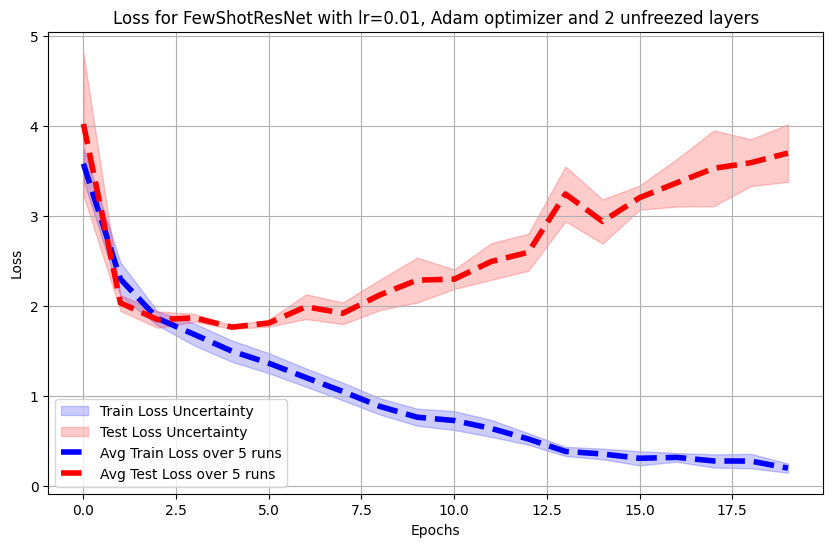

In [11]:
experiment_name = "FewShotResNet with lr=0.01, Adam optimizer and 2 unfreezed layers"
multiple_runs_with_uncertainty_band(metrics_list, f"Accuracy for {experiment_name}", f"Loss for {experiment_name}")

In [12]:
metrics_list = []
for _ in range(5):
    model = FewShotResNet(num_classes=10)
    metrics, time = train_few_shot(model, train_dataloader, test_dataloader, epochs=20, lr=0.0001)
    metrics_list.append(metrics)

Train loss: 2.26034 | Train accuracy: 21.63%
Test loss: 2.04567 | Test accuracy: 27.08%

Train loss: 1.56027 | Train accuracy: 46.23%
Test loss: 1.85577 | Test accuracy: 33.93%

Train loss: 0.78542 | Train accuracy: 75.50%
Test loss: 2.11950 | Test accuracy: 34.72%

Train loss: 0.30267 | Train accuracy: 91.37%
Test loss: 2.47961 | Test accuracy: 37.70%

Train loss: 0.07426 | Train accuracy: 98.41%
Test loss: 2.70162 | Test accuracy: 39.68%

Train loss: 0.01553 | Train accuracy: 99.70%
Test loss: 2.99961 | Test accuracy: 40.67%

Train loss: 0.00452 | Train accuracy: 100.00%
Test loss: 3.20052 | Test accuracy: 39.98%

Train loss: 0.00198 | Train accuracy: 100.00%
Test loss: 3.34128 | Test accuracy: 39.58%

Train loss: 0.00122 | Train accuracy: 100.00%
Test loss: 3.48438 | Test accuracy: 39.38%

Train loss: 0.00092 | Train accuracy: 100.00%
Test loss: 3.55769 | Test accuracy: 39.58%

Train loss: 0.00074 | Train accuracy: 100.00%
Test loss: 3.64964 | Test accuracy: 39.88%

Train loss: 0.00

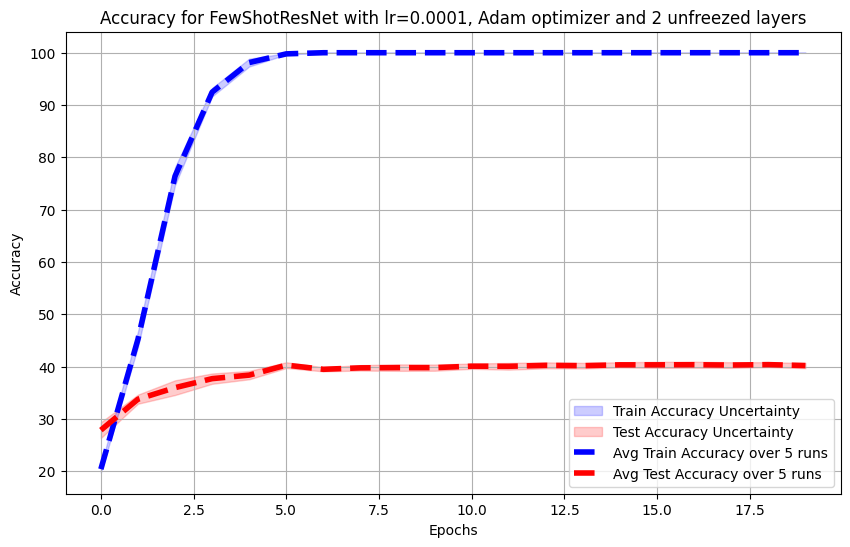

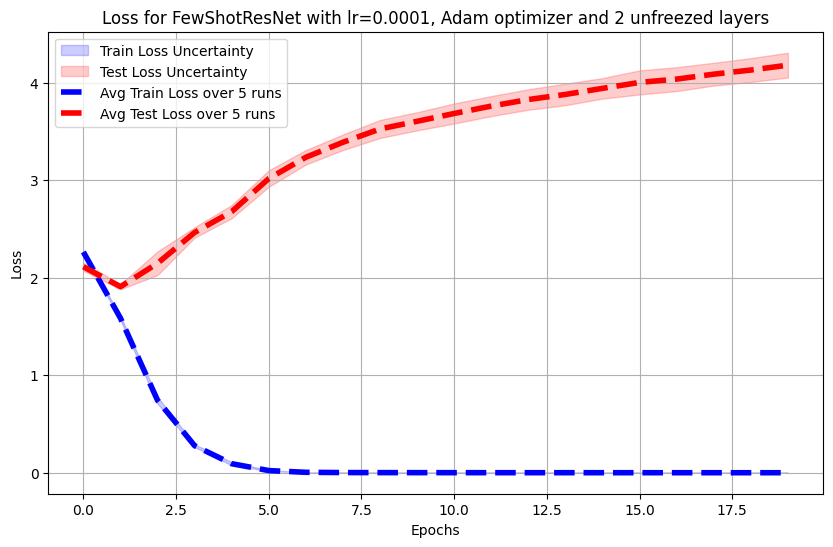

In [13]:
experiment_name = "FewShotResNet with lr=0.0001, Adam optimizer and 2 unfreezed layers"
multiple_runs_with_uncertainty_band(metrics_list, f"Accuracy for {experiment_name}", f"Loss for {experiment_name}")

In [14]:
metrics_list = []
for _ in range(5):
    model = FewShotResNet(num_classes=10)
    metrics, time = train_few_shot(model, train_dataloader, test_dataloader, epochs=20, lr=0.001, optimizer="sgd")
    metrics_list.append(metrics)

Train loss: 2.30855 | Train accuracy: 22.22%
Test loss: 2.08931 | Test accuracy: 31.15%

Train loss: 1.61783 | Train accuracy: 45.73%
Test loss: 1.96251 | Test accuracy: 31.35%

Train loss: 1.10132 | Train accuracy: 61.31%
Test loss: 2.03885 | Test accuracy: 34.72%

Train loss: 0.72298 | Train accuracy: 75.99%
Test loss: 2.28470 | Test accuracy: 39.38%

Train loss: 0.42600 | Train accuracy: 86.31%
Test loss: 2.72125 | Test accuracy: 37.40%

Train loss: 0.25953 | Train accuracy: 90.67%
Test loss: 2.95768 | Test accuracy: 35.52%

Train loss: 0.25668 | Train accuracy: 91.27%
Test loss: 2.84451 | Test accuracy: 38.99%

Train loss: 0.21777 | Train accuracy: 94.15%
Test loss: 2.81364 | Test accuracy: 40.38%

Train loss: 0.16055 | Train accuracy: 95.14%
Test loss: 2.96863 | Test accuracy: 37.80%

Train loss: 0.20377 | Train accuracy: 94.25%
Test loss: 2.88410 | Test accuracy: 35.52%

Train loss: 0.21081 | Train accuracy: 92.46%
Test loss: 3.12163 | Test accuracy: 36.90%

Train loss: 0.09161 |

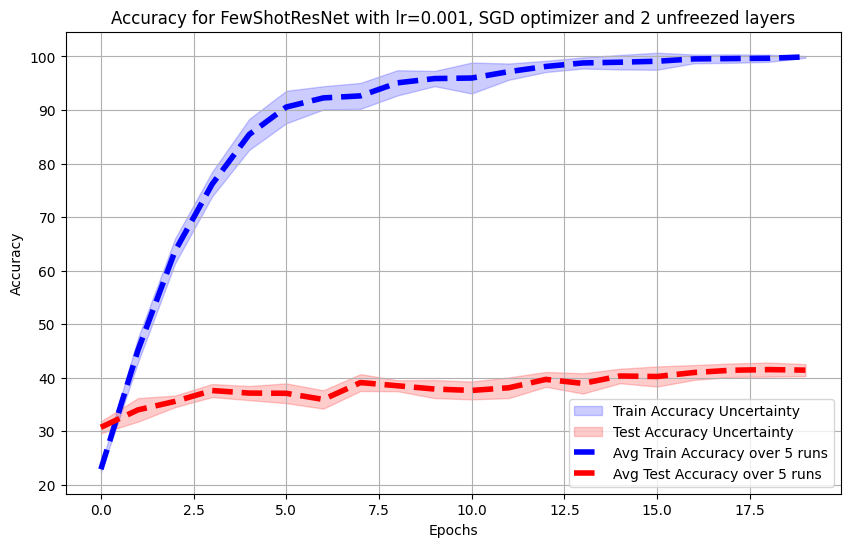

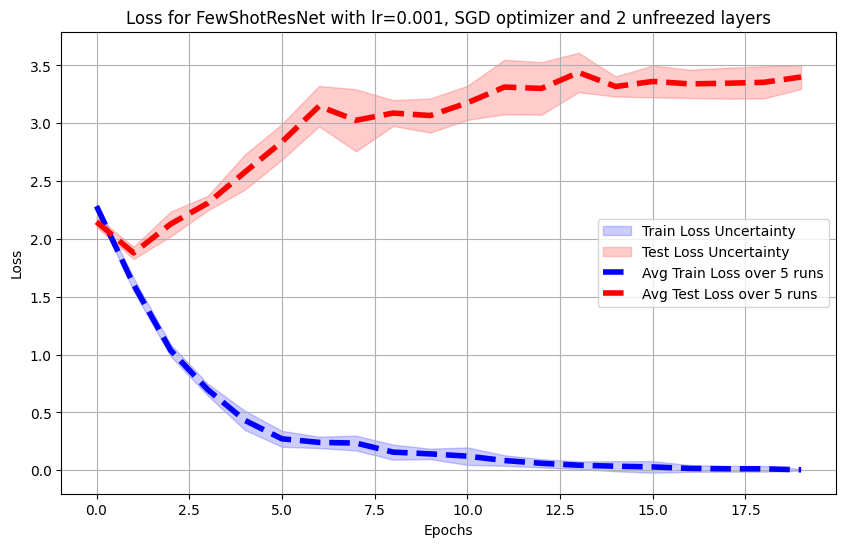

In [15]:
experiment_name = "FewShotResNet with lr=0.001, SGD optimizer and 2 unfreezed layers"
multiple_runs_with_uncertainty_band(metrics_list, f"Accuracy for {experiment_name}", f"Loss for {experiment_name}")

In [16]:
metrics_list = []
for _ in range(5):
    model = FewShotResNet(num_classes=10)
    metrics, time = train_few_shot(model, train_dataloader, test_dataloader, epochs=20, lr=0.001, unfreezed_layers=3)
    metrics_list.append(metrics)

Train loss: 2.36533 | Train accuracy: 20.24%
Test loss: 2.13022 | Test accuracy: 27.18%

Train loss: 2.00943 | Train accuracy: 23.71%
Test loss: 1.84760 | Test accuracy: 24.90%

Train loss: 1.81138 | Train accuracy: 28.67%
Test loss: 1.80446 | Test accuracy: 28.47%

Train loss: 1.67810 | Train accuracy: 36.90%
Test loss: 1.73341 | Test accuracy: 37.00%

Train loss: 1.47795 | Train accuracy: 42.96%
Test loss: 1.90032 | Test accuracy: 35.42%

Train loss: 1.34488 | Train accuracy: 50.20%
Test loss: 1.66614 | Test accuracy: 39.19%

Train loss: 1.24540 | Train accuracy: 55.16%
Test loss: 1.75849 | Test accuracy: 37.80%

Train loss: 1.04136 | Train accuracy: 60.42%
Test loss: 1.96934 | Test accuracy: 35.91%

Train loss: 0.95967 | Train accuracy: 65.28%
Test loss: 1.96447 | Test accuracy: 39.38%

Train loss: 0.81891 | Train accuracy: 70.34%
Test loss: 2.20343 | Test accuracy: 36.81%

Train loss: 0.70398 | Train accuracy: 75.50%
Test loss: 1.94274 | Test accuracy: 39.48%

Train loss: 0.51562 |

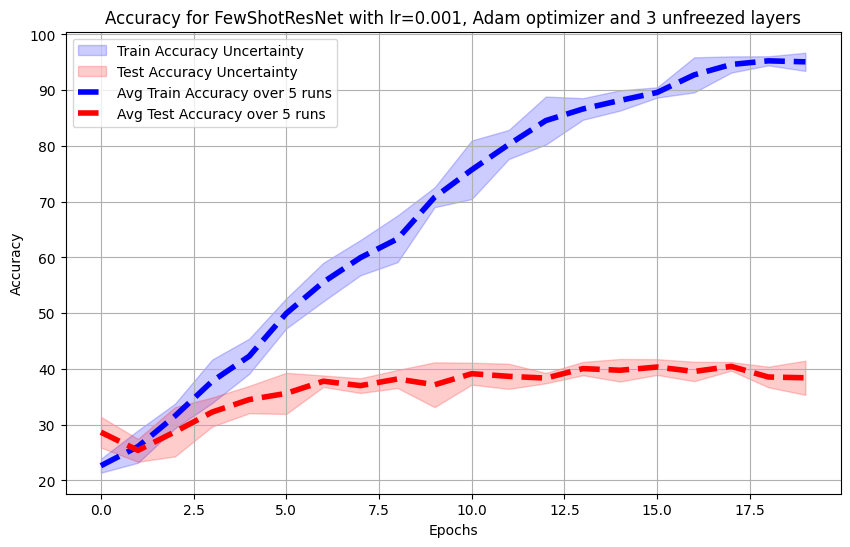

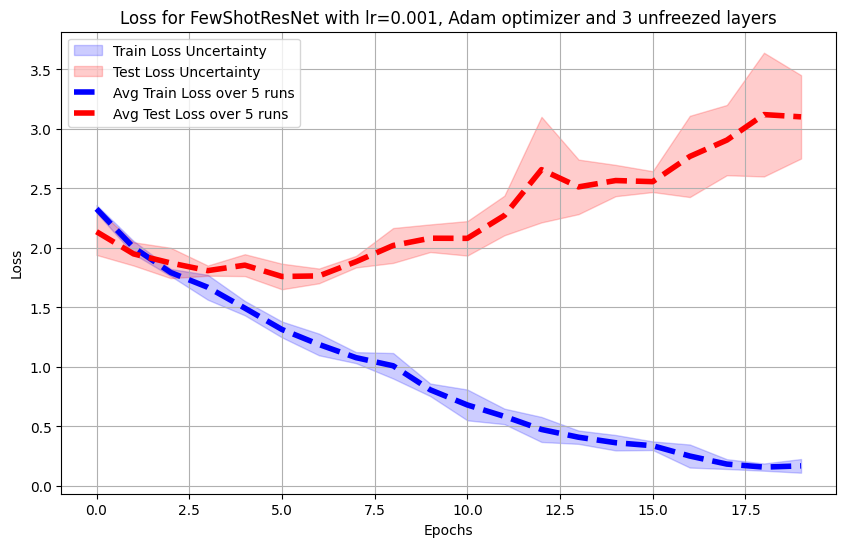

In [17]:
experiment_name = "FewShotResNet with lr=0.001, Adam optimizer and 3 unfreezed layers"
multiple_runs_with_uncertainty_band(metrics_list, f"Accuracy for {experiment_name}", f"Loss for {experiment_name}")

In [18]:
metrics_list = []
for _ in range(5):
    model = FewShotResNet(num_classes=10)
    metrics, time = train_few_shot(model, train_dataloader, test_dataloader, epochs=20, lr=0.001, unfreezed_layers=1)
    metrics_list.append(metrics)

Train loss: 2.39619 | Train accuracy: 25.99%
Test loss: 2.27868 | Test accuracy: 32.84%

Train loss: 1.58134 | Train accuracy: 46.73%
Test loss: 2.00010 | Test accuracy: 30.85%

Train loss: 1.02734 | Train accuracy: 64.68%
Test loss: 2.13758 | Test accuracy: 34.72%

Train loss: 0.80904 | Train accuracy: 72.92%
Test loss: 2.27166 | Test accuracy: 35.12%

Train loss: 0.62795 | Train accuracy: 78.57%
Test loss: 2.58755 | Test accuracy: 34.23%

Train loss: 0.50538 | Train accuracy: 83.33%
Test loss: 2.57695 | Test accuracy: 33.13%

Train loss: 0.48730 | Train accuracy: 85.81%
Test loss: 3.01185 | Test accuracy: 33.43%

Train loss: 0.39954 | Train accuracy: 86.61%
Test loss: 3.33912 | Test accuracy: 34.52%

Train loss: 0.36319 | Train accuracy: 88.19%
Test loss: 3.18826 | Test accuracy: 34.52%

Train loss: 0.27743 | Train accuracy: 91.07%
Test loss: 3.05832 | Test accuracy: 38.29%

Train loss: 0.09407 | Train accuracy: 96.33%
Test loss: 3.97702 | Test accuracy: 35.22%

Train loss: 0.20548 |

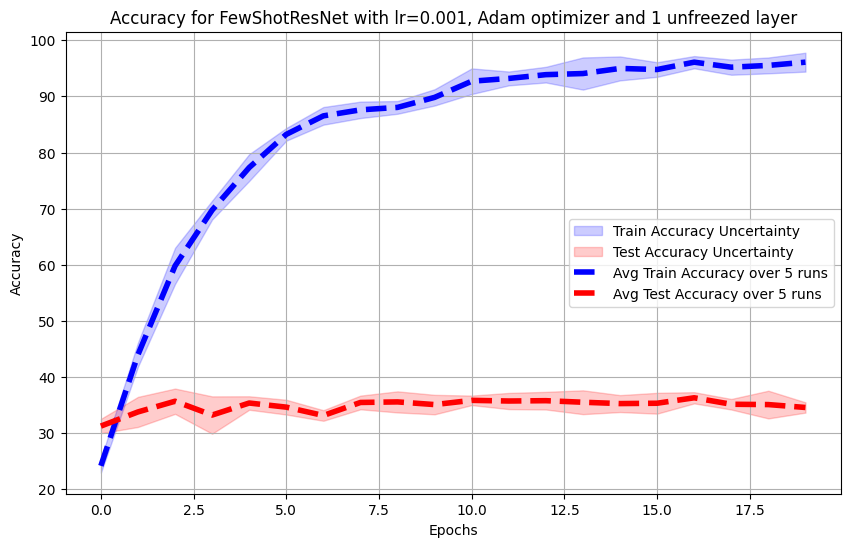

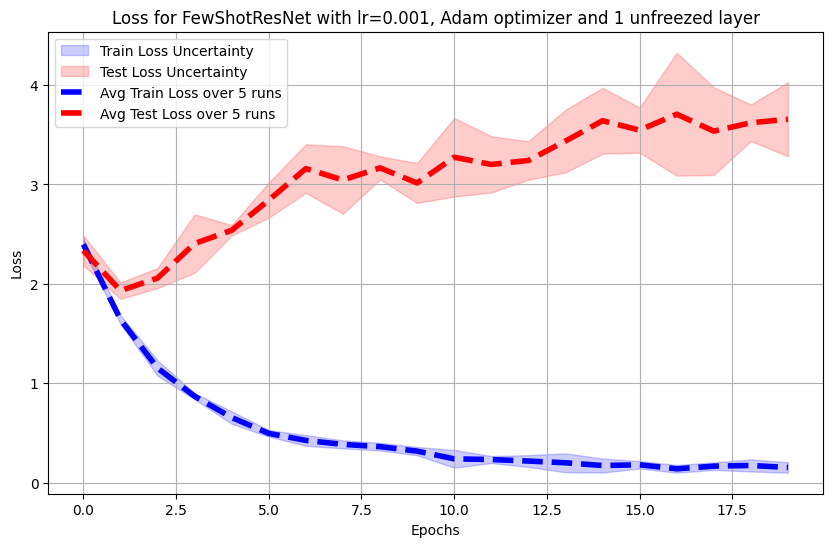

In [19]:
experiment_name = "FewShotResNet with lr=0.001, Adam optimizer and 1 unfreezed layer"
multiple_runs_with_uncertainty_band(metrics_list, f"Accuracy for {experiment_name}", f"Loss for {experiment_name}")

In [20]:
import torch.nn.functional as F
class CosineClassifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(num_classes, in_features))  # Class prototypes

    def forward(self, x):
        x = F.normalize(x, dim=1)
        w = F.normalize(self.weights, dim=1)
        return torch.mm(x, w.T)  # Cosine similarity
    
metrics_list = []
for _ in range(5):
    model = FewShotResNet(num_classes=10)
    model.backbone.fc = CosineClassifier(model.backbone.fc.in_features, 10)
    metrics, time = train_few_shot(model, train_dataloader, test_dataloader, epochs=30, lr=0.001)
    metrics_list.append(metrics)

Train loss: 2.17093 | Train accuracy: 29.86%
Test loss: 2.11086 | Test accuracy: 34.92%

Train loss: 2.05336 | Train accuracy: 42.26%
Test loss: 2.06636 | Test accuracy: 37.80%

Train loss: 2.00835 | Train accuracy: 46.83%
Test loss: 2.05820 | Test accuracy: 38.59%

Train loss: 1.95065 | Train accuracy: 55.36%
Test loss: 2.05878 | Test accuracy: 39.58%

Train loss: 1.92518 | Train accuracy: 59.42%
Test loss: 2.02789 | Test accuracy: 42.66%

Train loss: 1.87168 | Train accuracy: 65.97%
Test loss: 2.06610 | Test accuracy: 36.81%

Train loss: 1.84125 | Train accuracy: 69.74%
Test loss: 2.05990 | Test accuracy: 39.68%

Train loss: 1.80839 | Train accuracy: 73.21%
Test loss: 2.03566 | Test accuracy: 40.67%

Train loss: 1.77509 | Train accuracy: 76.98%
Test loss: 2.01576 | Test accuracy: 42.76%

Train loss: 1.77122 | Train accuracy: 76.39%
Test loss: 2.01628 | Test accuracy: 43.75%

Train loss: 1.72140 | Train accuracy: 83.23%
Test loss: 2.01408 | Test accuracy: 43.85%

Train loss: 1.69247 |

Cosine Classifier doesn't help I guess

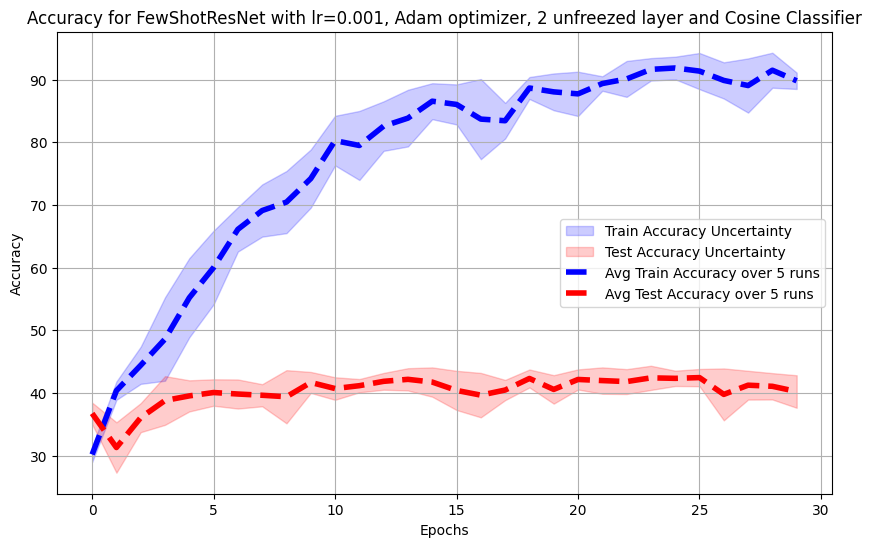

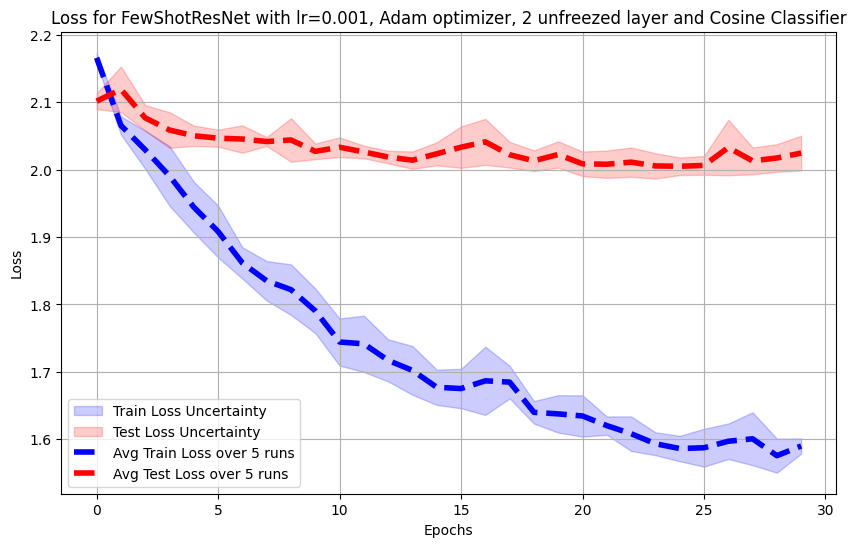

In [21]:
experiment_name = "FewShotResNet with lr=0.001, Adam optimizer, 2 unfreezed layer and Cosine Classifier"
multiple_runs_with_uncertainty_band(metrics_list, f"Accuracy for {experiment_name}", f"Loss for {experiment_name}")